# Perceptron
In the Supervised Learning Problem we consider data like the following

<IPython.core.display.Javascript object>


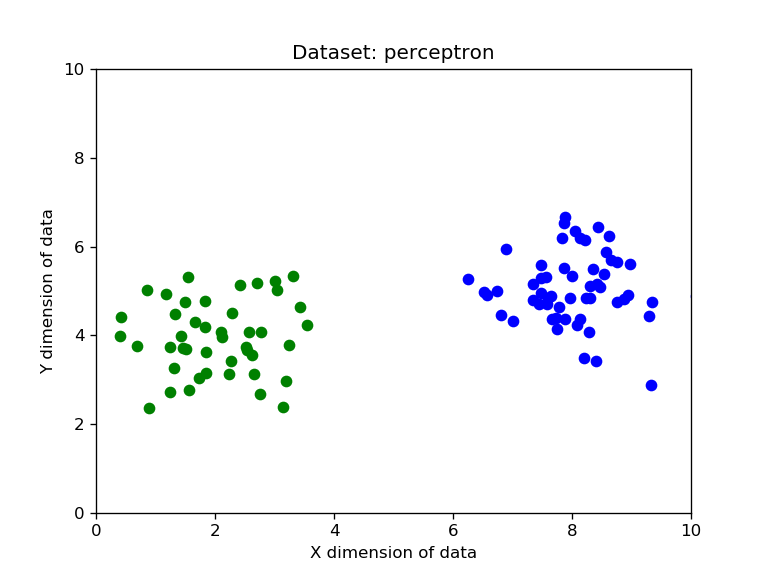

In [3]:
%matplotlib notebook
import dataset as ds

data = ds.DataSet("perceptron")
data.plot() # draw dashed line between the clases

Notice that the two groups of points could be seperated by a line. We say that the data is *linearly seperable*. 

<IPython.core.display.Javascript object>


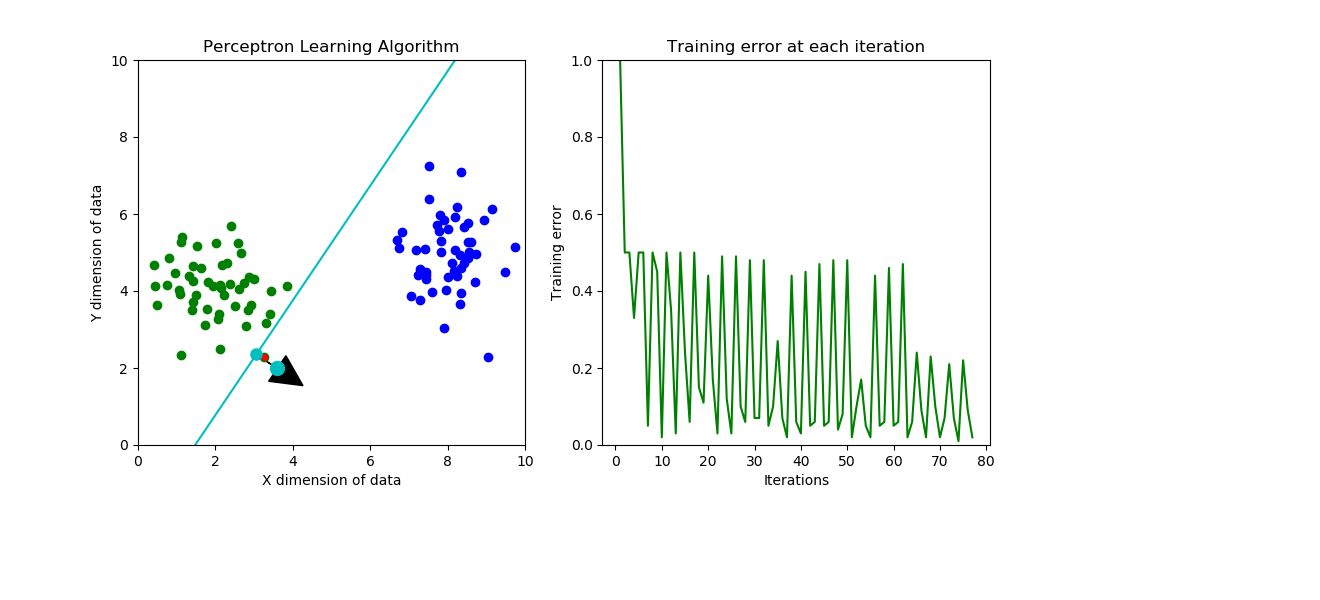

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in double_scalars
/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in double_scalars
/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in double_scalars
/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

class Perceptron:

    def __init__(self, learning_rate, visualize = False, sleep=0.0):
        self.w = None
        self.learning_rate = learning_rate
        self.visualize = visualize
        self.sleep = sleep
        
        if self.visualize: 
            self.fig, (self.ax_data, self.ax_errors) = plt.subplots(1, 2, figsize=(11, 5))
            self.errors = []
            self.ax_data.set_title("Perceptron Learning Algorithm")
            self.ax_data.set_xlabel("X dimension of data")
            self.ax_data.set_ylabel("Y dimension of data")
            self.ax_errors.set_title("Training error at each iteration")
            self.ax_errors.set_xlabel("Iterations")
            self.ax_errors.set_ylabel("Training error")
            
    def fit(self, X, y):
        """ Train the Perceptron on data X with labels y. 
        
        Parameters
        ----------
        X:    Matrix with shape (n, d) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry. 
        
        Returns
        -------
        """
        n, d = X.shape
        
        # Initialize weights 
        self.w = np.zeros(d)
        
        # Get a miss classified point. If all are classified correctly, the 
        # function will return False. 
        all_classified_corectly, miss_classified_point, miss_classified_label = self.miss_classified(X, y)

        while not all_classified_corectly:
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            
            # Update weights
            self.w += self.learning_rate * miss_classified_point * miss_classified_label
        
            # Get a new miss classified point. 
            all_classified_corectly, miss_classified_point, miss_classified_label = self.miss_classified(X, y)
            
        # Visualize the last round if enabled
        if self.visualize: self.visualize_step(X, y)
            
    def predict(self, X):
        """ Predicts the class of X given the trained weights. 
        
        Parameters
        ----------
        X:             Matrix with shape (n, d) with data point x_i as the i'th row. 
        
        Returns
        -------
        predictions:   Array with shape (n, ) holding the i'th prediction as entry i. 
        """
        return np.sign(X @ self.w)
        

    def miss_classified(self, X, y):
        """ Finds a miss classified label, returns False if all points are correctly classified. 
        
        Parameters
        ----------
        X:    Matrix with shape (n, d) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry. 
        
        Returns
        -------
        miss_classified_point:    The miss classified point, if no such point return False. 
        miss_classified_label:    The label of the miss classified point, if no such point return False. 
        """
        # Predict the class of each data point. 
        predictions = self.predict(X)
        
        # Get the number of miss classified points
        miss_classified_count = sum(predictions != y)
        
        # Return False if all points are correctly classified. 
        if miss_classified_count == 0: return True, None, None
        
        # Filter out the points where predictions disagree with labels. 
        miss_classified_points = X[predictions != y]
        miss_classified_labels = y[predictions != y]
        
        # Return te first miss classified point
        return False, miss_classified_points[0], miss_classified_labels[0]
        
        
    def error(self, X, y):
        """
        
        """
        n, d = X.shape
        return 1/n * sum(self.predict(X) != y) 
        
    
    def visualize_step(self, X, y): 
        """ Visualizes a step of the Perceptron learning algorithm. Assumes the data
        is 2-dimensional (with bias encoded so actually 3 dimensional). Throws an exception 
        if this is not the case. 
        
         Parameters
        ----------
        X:    Matrix with shape (n, 2) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry.         
        """
        # Check dimension of data. 
        n, d = X.shape
        assert d == 3, "Data should be two dimensional with bias encoded. "
        
        # Split data into classes
        X_class_0 = X[y==-1]
        X_class_1 = X[y==1]
        
        
        # Draw the different classes of data
        self.ax_data.cla()
        self.ax_data.set_xlim(0, 10)
        self.ax_data.set_ylim(0, 10)
        
        self.ax_data.plot(X_class_0[:,1], X_class_0[:,2], 'go')
        self.ax_data.plot(X_class_1[:,1], X_class_1[:,2], 'bo')
        
              
        # Draw the hyperplane
        w = self.w
        y0 = (-w[1]*0 - w[0]) / w[2]
        y1 = (-w[1]*10 - w[0]) / w[2]
        self.ax_data.plot([0, 10], [y0, y1], '-c', ms="8")
        
        
        # Highlight missclassified points, and highlight the chosen one. 
        # Predict the class of each data point. 
        predictions = self.predict(X)
        
        # Get the number of miss classified points
        miss_classified_count = sum(predictions != y)
        
        # Proceed only if there are miss classified points. 
        if miss_classified_count != 0: 
            
            # Filter out the points where predictions disagree with labels. 
            miss_classified_points = X[predictions != y]
            miss_classified_labels = y[predictions != y]
            
            # Mark all the miss classified points by a yellow cross 'yx'. 
            self.ax_data.plot(miss_classified_points[:, 1], miss_classified_points[:, 2], 'ro', ms=4)
            
            # Mark the chosen miss classified point by a large red dot. 
            miss_classified_point = miss_classified_points[0]
            self.ax_data.plot(miss_classified_point[1], miss_classified_point[2], 'co', ms=10)
                        
            # Draw an arrow from hyperplane towards this point. 
            # hypothesis is f(x)= -w[1]/w[2] * x - w[0]/w[2]
            # we want the arrow to be orthogonal to f(x), so if we think of it
            # as a line the slopes both lines should give -1.  
            # The intercept of the line is now given b=y_mc + x_mc*w[1]/w[2].
            # Then we want to compute the intersection point of the two lines and we are done. 
            x_mc = miss_classified_point[1]
            y_mc = miss_classified_point[2]
            
            f_a = -w[1]/w[2]
            f_b = -w[0]/w[2]
            
            g_a = - 1 / f_a     # g_a*f_a = -1 => g_a = - 1 / f_a 
            g_b = y_mc - g_a * x_mc # y = a*x + b => b = y - a*x
            
            x_intercept = (g_b - f_b) / (f_a - g_a)
            y_intercept = x_intercept * f_a + f_b
            
            self.ax_data.plot(x_intercept, y_intercept, 'co', ms=8)
            self.ax_data.arrow(x_intercept, y_intercept, x_mc - x_intercept, y_mc - y_intercept, 
                               head_width=0.8, head_length=0.8, fc='k', ec='k')
        
        # Draw error of iterations
        self.ax_errors.cla()
        self.ax_errors.set_ylim(0, 1)
        self.errors.append(self.error(X, y))
        self.ax_errors.plot(range(1, len(self.errors)+1), self.errors, '-g')
        
         # Titles and axis labels
        self.ax_data.set_title("Perceptron Learning Algorithm")
        self.ax_data.set_xlabel("X dimension of data")
        self.ax_data.set_ylabel("Y dimension of data")
        self.ax_errors.set_title("Training error at each iteration")
        self.ax_errors.set_xlabel("Iterations")
        self.ax_errors.set_ylabel("Training error")
        
        # Update plot
        self.fig.canvas.draw()
        
        time.sleep(self.sleep)


data = DataSet("perceptron")
X = data.X
y = data.y
        
perceptron = Perceptron(learning_rate = 1, visualize = True, sleep=0.78)

perceptron.fit(X, y)

# TODO: Did we not prove something like (he same point can never be miss classified in consecutive iterations? 
# This seems to be happening)

# The Pocket Algorithm

Modify the algorithm to run for iterations $T$ and return the best hypothesis seen so far. 

<IPython.core.display.Javascript object>


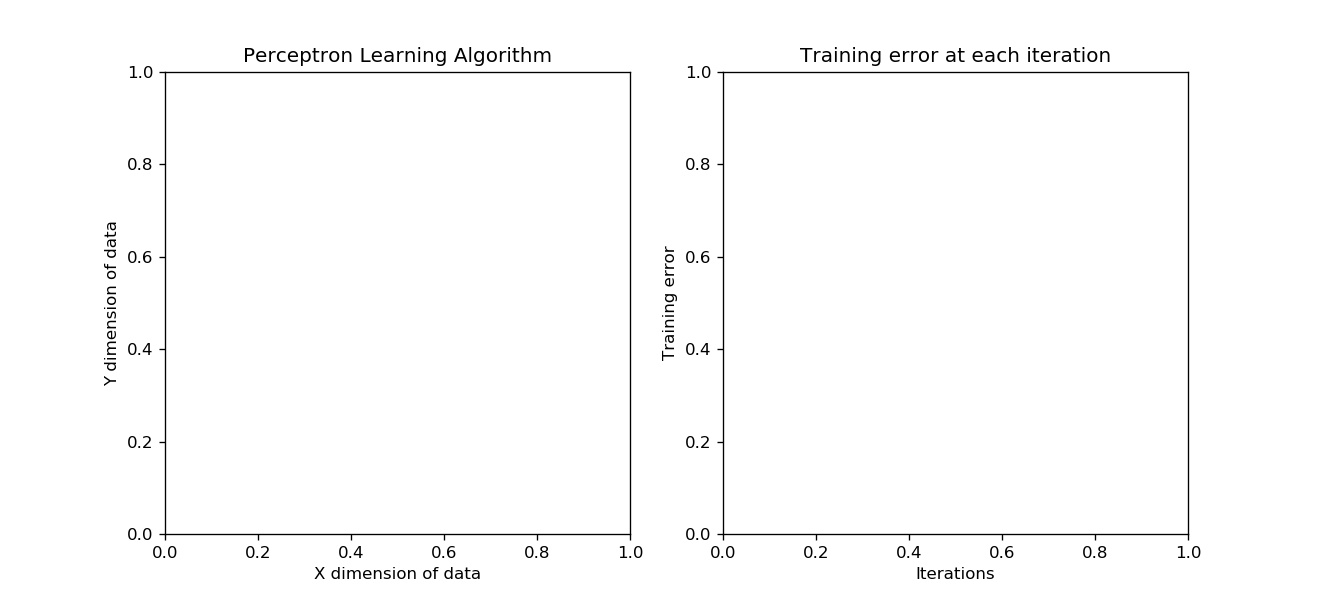

In [127]:
# Potential features to add:
# - Draw the current best hypothesis (just override function, call parrent class visualize, then draw with dashed lines on top)
# - Do the same for the error. 

class Pocket(Perceptron): 
    def __init(self):
        pass
    
    def fit(self, X, y, T):
        """ Train the Perceptron on data X with labels y. Save the best classifier so far and 
        stop after T iterations. 
        
        Parameters
        ----------
        X:    Matrix with shape (n, d) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry. 
        
        Returns
        -------
        """
        n, d = X.shape
        
        # Initialize weights 
        self.w = np.zeros(d)
        
        # Get a miss classified point. If all are classified correctly, the 
        # function will return False. 
        all_classified_corectly, miss_classified_point, miss_classified_label = self.miss_classified(X, y)
        
        best_error = 1.0
        best_w = np.zeros(d)

        for i in range(T): # DIFFERENT FROM POCKET!
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            
            # Update weights
            self.w += self.learning_rate * miss_classified_point * miss_classified_label
        
            current_error = self.error(X, y)
            if current_error < best_error: 
                best_error = current_error
        
            # Get a new miss classified point. 
            all_classified_corectly, miss_classified_point, miss_classified_label = self.miss_classified(X, y)
            
        # Visualize the last round if enabled
        if self.visualize: self.visualize_step(X, y)
    
    
pocket = Pocket(learning_rate = 1, visualize = True, sleep=0.78)